# THEORY OF APPROXIMATE REACTION NETWORKS

In [1]:
import numpy as np
import pandas as pd
import tellurium as te
import controlSBML as ctl
import control
import matplotlib.pyplot as plt

# Helpers 

In [96]:
TEST_MODEL = """
model *main()
$S1 -> S2; TEST_K12*S1
S2 ->; TEST_K2*S2

S1 = 0
TEST_K12 = 2
TEST_K2 = 1
end
"""

In [105]:
TEST_K12 = 2
TEST_K2 = 1
TEST_TF = control.TransferFunction([TEST_K12], [1, TEST_K2])

In [108]:
def plotStep(model=TEST_MODEL, tf=None, selections=None, title="", figsize=(8, 8), is_plot=True, **kwargs):
    """
    Assumes that input is S1 and output is S2
    """
    _, ax = plt.subplots(1, figsize=figsize)
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    if selections is not None:
        new_selections = list(selections)
        new_selections.insert(0, "time")
        rr.selections = new_selections
    data = rr.simulate()
    if tf is not None:
        times, predictions = control.step_response(tf, T=data["time"])
        if "S1" in kwargs.keys():
            mult = S1
        else:
            mult = 1
        predictions = mult*predictions
        ax.scatter(data[:, 1], predictions, color="red", marker="*")
        ax.set_xlabel("simulated")
        ax.set_ylabel("predicted")
        max_simulated = np.max(data[:, 1])
        max_predictions = np.max(predictions)
        max_value = max(max_simulated, max_predictions)
        ax.plot([0, max_value], [0, max_value], linestyle="--")
    else:
        ax.scatter(data[:, 0], data[:, 1], marker="o")
        ax.set_xlabel("time")
    ax.set_title(title)
    if not is_plot:
        plt.close()

plotStep(S1=5, TEST_K12=TEST_K12, TEST_K2=TEST_K2, selections=["S2"], title="test", figsize=(3,3), is_plot=False)
plotStep(S1=5, tf=TEST_TF, TEST_K12=TEST_K12, TEST_K2=TEST_K2, selections=["S2"], title="test", figsize=(3,3), is_plot=False)
print("OK!")

OK!


# Theory

The idea is to develop transfer functions based on an algebra on reaction networks.
**Outline**
1. Consider the network
  * $S_1 \rightarrow S_2$ at rate $k_{1,2}S_1$
  * $S_2 \rightarrow ∅$ at rate $k_2 S_2$
1. The foregoing has the transfer function $\frac{k_2}{s + k_{1,2}}$.
1. Creating a sequential path of networks multiplies their transfer functions. The result is a composite system that has all the poles and zeroes of the component systems.
1. Summing the outputs (two paths to equivalent chemical species) adds transfer functions. The result is a composite system that has the poles of the component systems but different zeroes.
1. Feedback transforms the poles of a transfer function.

**Claim**. Given a proper transfer function whose numerator and denominator are polynomials with real coefficients, we can construct a reaction network with the given transfer function.

**Implications**
1. Can design oscillators.
1. Can approximate reaction networks.
1. Have an understanding of poles and zeros.

## Concepts and notation

We use subscripted and superscripted $S$ to indicate chemical species. Where there is no confusion, we use the same symbol for its concentration as well. In contexts where there may be confusion between the name and its concentration, we explicitly indicate a concentration using square brackets. For example, $[S_0]$ is the concentration of species $S_0$.

* A (uni-uni) **reaction** is a triple expressed as $S_I \xrightarrow{k} S_O$ indicates the transformation of mass from species $S_I$ to $S_O$ using mass action with the kinetic constant $k$. If $k < 0$, then $S_O$ is transformed into $S_I$; that is, $S_O \xrightarrow{-k} S_I$. If $S_I = \emptyset$ or $S_O = \emptyset$, then this a boundary reaction. For an input boundary, $k_I$ is a fixed rate. If $S_O = \emptyset$, then this is a degradation reaction.

* A **SISO Reaction Network (SRN)** is $N = <S, S_I, S_O, R, k_I, k_O>$ where:
    * $S$ is a set of chemical species
    * $S_I, S_O \in S$ are input and output species.
    * $R$ is a set of reactions.
    * $k_I S_I$ is the rate at which the input is consumed.
    * $k_O S_O$ is the rate at which the output is degraded.

* We indicate components of an object using a dot ("."), such as $N.S_I$


## Network Operations

These are operations applied to SISO reaction networks that produce a new SISO reaction network.
In the sequel, $N^A, N^B$ are SRNs.

**Sequence** is an asymmetric, binary operation.
Let $N$,, $N^A, N^B$ be SISO reaction networks such that $N^A.S \bigcap N^B.S = \{N^A.S_O = S^B.S_I \}$. 
Sequence applied these SRNs, denoted by $N = N^A \circ  N^B$, is:
* $S = N^A.S \bigcup N^B.S$
* $S_I =N^A.S_I$
* $S_O = N^B.S_O$
* $R = R^A \bigcup R^B$
* $k_I = N^A.k_I$
* $k_O = N^B.k_O$

**Forkjoin** is a symmetric, binary operation.
Assume that $N^A.S \bigcap N^B.S = \{N^A.S_I\} = \{N_B.S_I \}$.
The forkjoin of these networks, denoted by $N = N^A + N^B$, is:
* $S = N^A.S \bigcup N^B.S \bigcup \{ O \}$
* $S_I = N^A.S_I = N^B.S_I$
* $S_O$ is a new species defined as $\{ N^A.S_O, N^B.S_O\}$
* $R = R^A \bigcup R^B$
* $k_I = N^A.k_I + N^B.k_I$
* $k_O = N^A.k_O + N^B.k_O$

**Amplify** is a unary operation.
$amplify(N, K, k)$, $0 \lt K, k$. $[S_O] = K[N.S_O]$.
* $S = N.S$
* $S_I = N.S_I$
* $S_O = N.S_O$
* $R = N.R \bigcup \{N.S_I \xrightarrow{k} N.S_O,~ N.S_O \xrightarrow{Kk} N.S_I \}$
* $k_I = N.k_I + \frac{1}{k}$
* $k_O = N.k_O + \frac{K}{k}$

**Loop** is a unary operation.
$loop(N, S_I, S_O, k_1, k_2, k)$ is a unary operation, where: $k$ is real. The loop operation is similar to electrical circuits that use an operational amplifier.
* $S = N.S \bigcup \{S_I, S_O \}$
* $R = R \bigcup \{S_I \xrightarrow{k_1} N.S_I,~ N.S_O \xrightarrow{k} N.S_I,~ N.S_O \xrightarrow{k_2} S_O \}$
* $k_I = N.k_I$
* $k_O = N.k_O + k$

**Insulate** is a unary operation that separates a network from its environment.
$insulate(N, S_I, S_O, k_1, k_2)$ is a unary operation.
* $S = N.S \bigcup \{S_I, S_O \}$
* $R = R \bigcup \{S_I \xrightarrow{k_1} N.S_I,~ N.S_O \xrightarrow{k_2} S_O \}$
* $k_I = k_1$
* $k_O = 0$

Note that we can just insulate the input by setting $k_2 = 0$, and simularly, just insulate the output by $k_1 = 0$.

**Instantiate** is a uniary operation.
$instantiate(N)$ creates a network with the same reaction and kinetic constants but unique species.

## Networks

### Two Species Reaction Network (2SRN)

* $S = \{S_I, S_O\}$
* $R = \{ S_I \xrightarrow{k_{IO}} S_O, S_O \xrightarrow{k_O} ∅ \}$
* $k_I = k_{IO}
* $k_O = k_{O}$

Claim that the transfer function from $S_I$ to $S_O$ is $\frac{k_I + k_{IO}}{s + k_O}$.

### Sequence two 2SBNs

Let $N^A$, $N^B$ be 2SBN with $S^A.S_O = S^B.S_I$.
Then $N = N^A \circ N^B$ has the following properties:
* $S = \{S^A_I, S^A_O = S^B_I, S^B_O \}$
* $R = R^A \bigcup R^B$
* $S_I = S^A_I$
* $S_O = S^B_O$
* $k_I = N^A.k_I$
* $k_O = k^B_O$

$N$
has transfer function $H(s)$
$$H(s) = H^A(s) H^B(s)\frac{s + k^A_O}{s+ k^B_I + k^A_O}$$.

### Forkjoin two 2SBNs

Let $N^A$, $N^B$ be 2SBN with $S^A.S_I = S^B.S_I$.
Then $N = N^A + N^B$ has the following properties:
* $S = \{S^A_O, S^A.S_I = S^B.S_I, S^B_O \}$
* $R = R^A \bigcup R^B$
* $S_I = S^A.S_I = S^B.S_I$
* $S_O = \{ S^A.S_O, S^B.S_O \}$
* $k_I = k^A_I + k^B_I$
* $k_O = k^A_O + k^B_O$

$N$
has transfer function $H(s)$
$$H(s) = H^A(s) + H^B(s)$$.

## Claims

1. **Transfer function for sequence**. Let $N_1, N_2$ be reaction networks with transfer functions $H_1(s), H_2(s)$ that satisfy the conditions for concatenation. Let $N = N_1 \circ N_2$, and let $H(s)$ be its transfer function. Claim that $H(s) = H_1 (s) H_2(s)\frac{s + N^A.k_O}{s + N^A.k_O + N^B.k_I}$.
1. **Transfer function for forkjoin**. Let $N_1, N_2$ be reaction networks with transfer functions $H_1(s), H_2(s)$ that satisfy the conditions for branching. Let $H(s)$ be the transfer function for $N_1 + N_2$. Claim that $H(s) = H_1 (s) + H_2(s)$.
1. **Transfer function for scale**. Let $N_1$ be a reaction network with transfer function $H_1(s)$. Let $N  = K \times N_1$, and $H(s)$ be its transfer function. Claim that $H(s) = kH_1(s)$.
1. **Transfer function for loop**.
  1. Given, $N$, its transfer function $G(s) = \frac{N(s)}{D(s)}$. Find $S_O(s) = H(s) S_I(s)$ for $loop(N, k)$.
\begin{eqnarray}
G(s) & = & \frac{N(s)}{D_1 (s) (s + N.k_O)} \\
s S_O (s) & = & k_2 N.S_O (s)  \\
s N.S_O (s) & = & -k_2 N.S_O (s) -k N.S_O (s) + s N.S_I(s) G(s) \\
s N.S_I (s) & = & k N.S_O(s) + k_1 S_I (s) \\
s N.S_O (s) & = & -k_2 N.S_O (s) -k N.S_O (s) + G(s) (k N.S_O(s) + k_1 S_I (s) ) \\
N.S_O (s) & = & \frac{G(s) k_1 S_I (s) }{k + k_2 + k G(s)}  \\
S_O (s) & = & \frac{s}{k_2} \frac{ G(s) k_1 S_I (s) }{k + k_2 + k G(s)}  \\
H (s) & = &  \frac{ s k_1 G(s) }{k_2 (k + k_2 + k G(s))}  \\
& = & k_1 k_2 (k + k_2) \frac{ s G(s) }{ 1 + k^{\prime} G(s)},~ k^{\prime} = \frac{k}{k_2(k + k_2)}  \\
\end{eqnarray}

## Notes
1. Apply insulate consistently.

# Numerical Studies

In [78]:
model1 = """
model *main()
$S1 -> S2; k12*S1
S2 ->; k2*S2
S1 =5
k12 = 2
k2 = 1
end
"""

model2 = """
model *main()
$S1 -> S2; k12*S1
S2 ->; k2*S2
S2 -> S3; k23*S2
S3 ->; k3*S3
S1 =5
k12 = 2
k2 = 1
k23 = 3
k3 = 2
end
"""

model3 = """
model *main()
$S2 -> S3; k23*S2
S3 ->; k3*S3
S2 =5
k23 = 3
k3 = 2
end
"""

model4 = """
model *main()
$S1 -> S2A; k12A*S1
S2A ->; k2A*S2A
$S1 -> S2B; k12B*S1
S2B ->; k2B*S2B
S2 := S2A + S2B
S1 =5
k12A =3
k12B = 2
k2A = 2
k2B = 2
S2A = 0
S2B = 0
end
"""

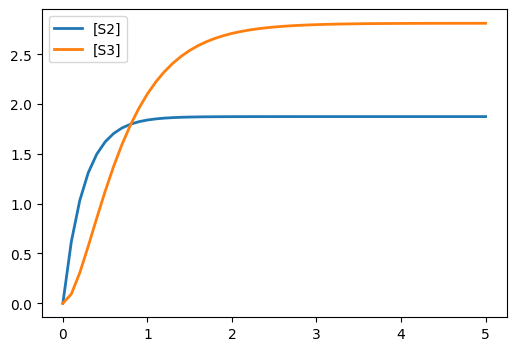

In [20]:
plotStep(model=model2, S1=5, k12=1.5, k2=1)

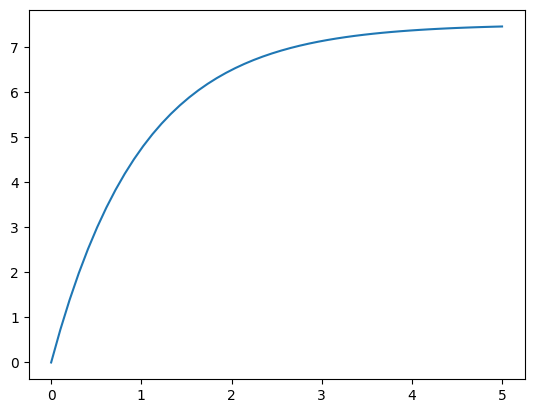

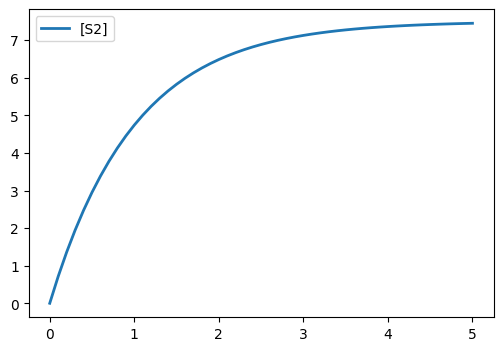

In [7]:
k12 = 1.5
k2 = 1
S1 = 5
tf = control.TransferFunction([k12], [1, k2])
tv, yv = control.step_response(tf, np.linspace(0, 5, 50))
plt.plot(tv, S1*yv)
plotStep(model=model1, S1=S1, k12=k12, k2=k2)

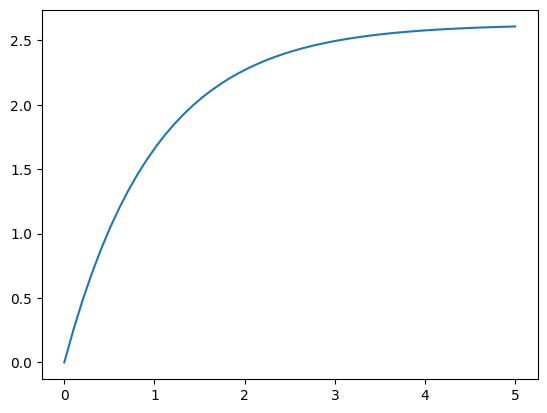

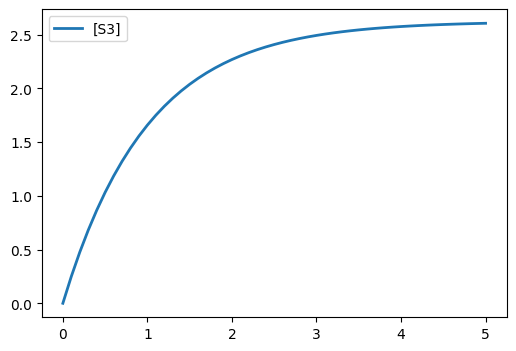

In [8]:
k23 = 1.5
k3 = 1
S2 = 1.75
tf = control.TransferFunction([k23], [1, k3])
tv, yv = control.step_response(tf, np.linspace(0, 5, 50))
plt.plot(tv, S2*yv)
plotStep(model=model3, S2=S2, k23=k23, k3=k3)

## Sequence

For all models, S1 is the input and S2 is the output.

In [110]:
model_sequence = """
model *main()
$S1 -> S2A; k12*S1
S2A ->; k2*S2A
S2A -> S2; k23*S2A
S2 ->; k3*S2
S1 =5
k12 = 2
k2 = 1
k23 = 3
k3 = 2
end
"""


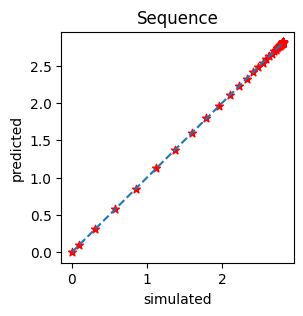

In [112]:
k12 = 1.5
k2 = 1
k23 = 3
k3 = 2
S1 = 5
tf1 = control.TransferFunction([k12], [1, k2])
tf2 = control.TransferFunction([k23], [1, k3])
tf3 = control.TransferFunction([1, k2], [1, k2+k23 ])
# tf3 adjusts for the consumption of S2 by the second network
tf = tf1*tf2*tf3
plotStep(model=model_sequence, tf=tf, S1=S1, k12=k12, k2=k2, k23=k23, k3=k3, selections=["S2"], title="Sequence", figsize=(3, 3))

## Forkjoin

In [113]:
model_forkjoin = """
model *main()
$S1 -> S2A; k12A*S1
S2A ->; k2A*S2A
$S1 -> S2B; k12B*S1
S2B ->; k2B*S2B
S2 := S2A + S2B
S1 =5
k12A =3
k12B = 2
k2A = 2
k2B = 2
S2A = 0
S2B = 0
end
"""

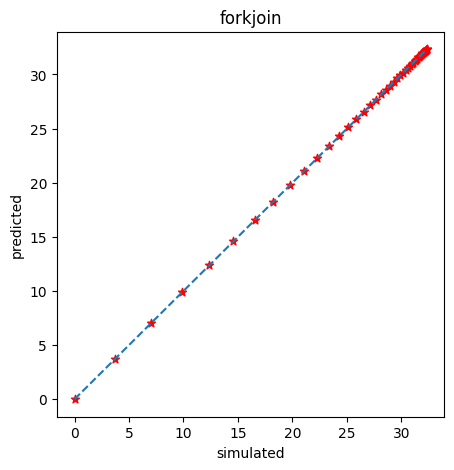

In [114]:
k12A = 5
k2A = 1
k12B = 3
k2B = 2
S1 = 5
tf1 = control.TransferFunction([k12A], [1, k2A])
tf2 = control.TransferFunction([k12B], [1, k2B])
tf = tf1 + tf2
plotStep(model=model_forkjoin, tf=tf, S1=S1, k12A=k12A, k2A=k2A, k12B=k12B, k2B=k2B, title="forkjoin", figsize=(5,5), selections=["S2"])

## Loop

In [116]:
# The looped network is S1A -> S2A, S2A ->;
model_loop = """
model *main()
// Boundary reactions
$S1 -> S1A; k1*S1
S2A -> S2; k2*S2A
// Looped network
S1A -> S2A; k12A*S1A
S2A -> ; k2A*S2A
// Added reactions
S2A -> S1A; k*S2A
S1 =5
k1 = 1
k2 = 2
k12A = 3
k2A = 2
k = 3
end
"""

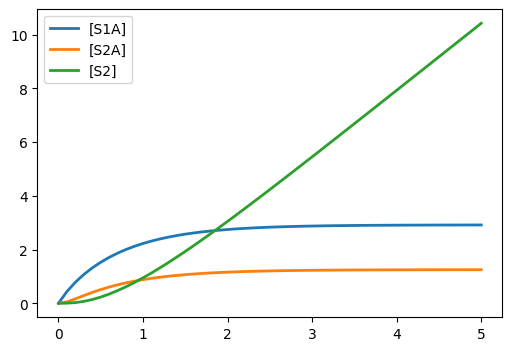

In [117]:
rr = te.loada(model_loop)
rr.simulate()
rr.plot()